In [1]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

In [2]:
network = pypsa.examples.scigrid_de(from_master=True)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.io:Imported network scigrid-de.nc has buses, generators, lines, loads, storage_units, transformers


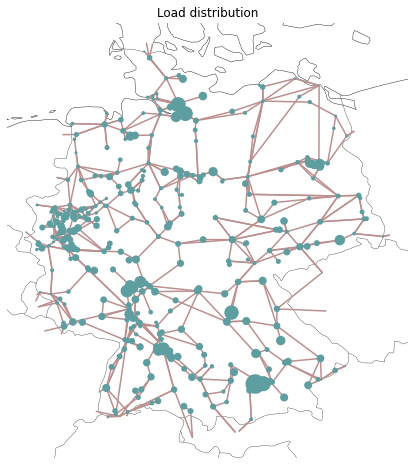

In [3]:
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8)
)

load_distribution = (
    network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()
)
network.plot(bus_sizes=1e-5 * load_distribution, ax=ax, title="Load distribution");

In [4]:
print(pypsa.__file__)

/home/xuwang/anaconda3/envs/SmartGrid/lib/python3.9/site-packages/pypsa/__init__.py


In [5]:
network.generators.groupby("carrier")["p_nom"].sum()

carrier
Brown Coal       20879.500000
Gas              23913.130000
Geothermal          31.700000
Hard Coal        25312.600000
Multiple           152.700000
Nuclear          12068.000000
Oil               2710.200000
Other             3027.800000
Run of River      3999.100000
Solar            37041.524779
Storage Hydro     1445.000000
Waste             1645.900000
Wind Offshore     2973.500000
Wind Onshore     37339.895329
Name: p_nom, dtype: float64

In [6]:
network.storage_units.groupby("carrier")["p_nom"].sum()

carrier
Pumped Hydro    9179.5
Name: p_nom, dtype: float64

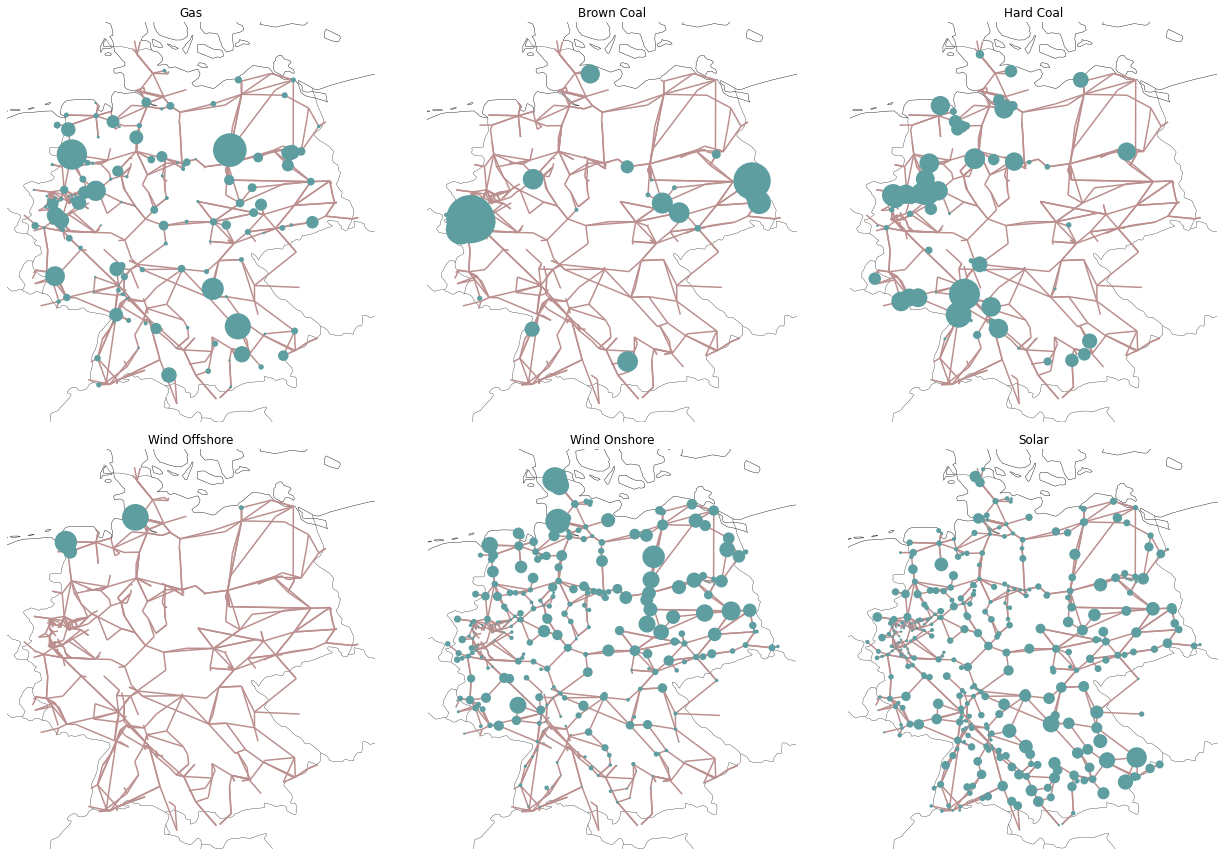

In [7]:
techs = ["Gas", "Brown Coal", "Hard Coal", "Wind Offshore", "Wind Onshore", "Solar"]

n_graphs = len(techs)
n_cols = 3
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1


fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols, subplot_kw={"projection": ccrs.EqualEarth()}
)
size = 6
fig.set_size_inches(size * n_cols, size * n_rows)

for i, tech in enumerate(techs):
    i_row = i // n_cols
    i_col = i % n_cols

    ax = axes[i_row, i_col]
    gens = network.generators[network.generators.carrier == tech]
    gen_distribution = (
        gens.groupby("bus").sum()["p_nom"].reindex(network.buses.index, fill_value=0.0)
    )
    network.plot(ax=ax, bus_sizes=2e-5 * gen_distribution)
    ax.set_title(tech)
fig.tight_layout()

In [8]:
contingency_factor = 0.7
network.lines.s_max_pu = contingency_factor

In [9]:
network.lines.loc[["316", "527", "602"], "s_nom"] = 1715

In [10]:
group_size = 4
network.storage_units.state_of_charge_initial = 0.0

for i in range(int(24 / group_size)):
    # set the initial state of charge based on previous round
    if i:
        network.storage_units.state_of_charge_initial = (
            network.storage_units_t.state_of_charge.loc[
                network.snapshots[group_size * i - 1]
            ]
        )
    network.lopf(
        network.snapshots[group_size * i : group_size * i + group_size],
        solver_name="cbc",
        pyomo=False,
    )

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.74s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.45e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.77s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.74e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.75s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 7.91e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.74s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.72s
INFO:pypsa.linopf:Solve linear problem using Cbc solver

In [11]:
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 1700.0]).index, axis=1, inplace=True
)
p_by_carrier.columns

Index(['Brown Coal', 'Gas', 'Hard Coal', 'Nuclear', 'Run of River', 'Solar',
       'Wind Offshore', 'Wind Onshore'],
      dtype='object', name='carrier')

In [12]:
colors = {
    "Brown Coal": "brown",
    "Hard Coal": "k",
    "Nuclear": "r",
    "Run of River": "green",
    "Wind Onshore": "blue",
    "Solar": "yellow",
    "Wind Offshore": "cyan",
    "Waste": "orange",
    "Gas": "orange",
}
# reorder
cols = [
    "Nuclear",
    "Run of River",
    "Brown Coal",
    "Hard Coal",
    "Gas",
    "Wind Offshore",
    "Wind Onshore",
    "Solar",
]
p_by_carrier = p_by_carrier[cols]

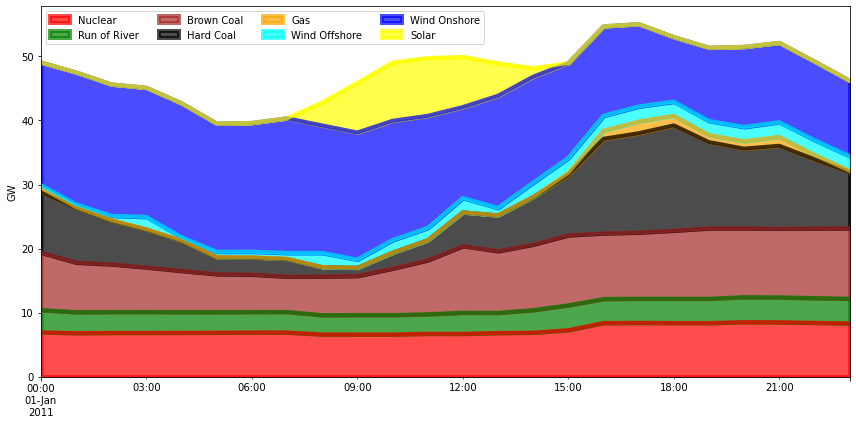

In [13]:
c = [colors[col] for col in p_by_carrier.columns]

fig, ax = plt.subplots(figsize=(12, 6))
(p_by_carrier / 1e3).plot(kind="area", ax=ax, linewidth=4, color=c, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()

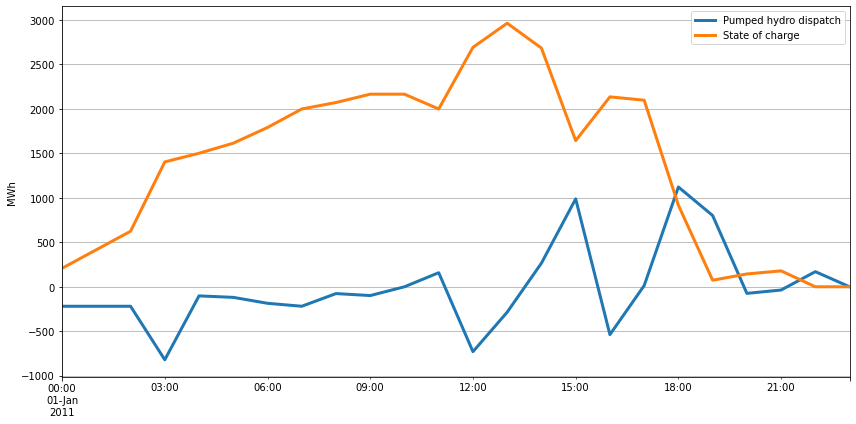

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")
fig.tight_layout()

In [15]:
'''
[now] should be ['2011-01-01 00:00:00'] it is the first time stemp of network.lines_t.p0
'''
loading = network.lines_t.p0.loc['2011-01-01 00:00:00'] / network.lines.s_nom
loading.describe()

count    852.000000
mean      -0.006955
std        0.265461
min       -0.700000
25%       -0.136290
50%        0.000000
75%        0.133174
max        0.700000
dtype: float64

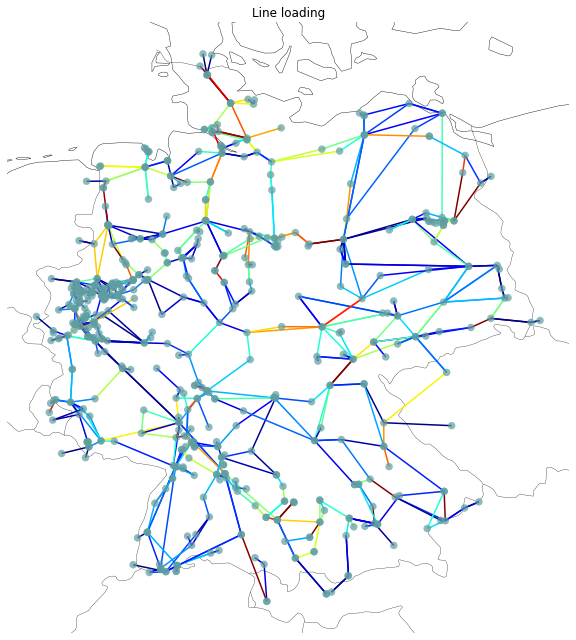

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))
network.plot(
    ax=ax,
    line_colors=abs(loading),
    line_cmap=plt.cm.jet,
    title="Line loading",
    bus_sizes=1e-3,
    bus_alpha=0.7,
)
fig.tight_layout();

In [17]:
network.buses_t.marginal_price.loc['2011-01-01 00:00:00'].describe()

count    585.000000
mean      24.293868
std       17.517895
min      -14.056907
25%       10.000000
50%       22.033831
75%       39.508735
max      116.547060
Name: 2011-01-01 00:00:00, dtype: float64

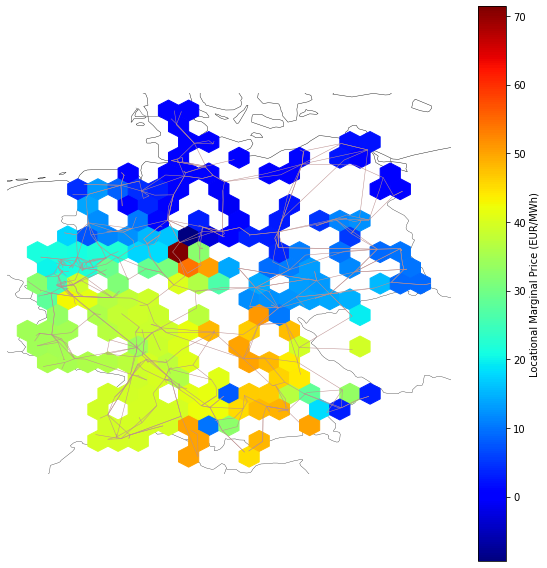

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 8))

plt.hexbin(
    network.buses.x,
    network.buses.y,
    gridsize=20,
    C=network.buses_t.marginal_price.loc['2011-01-01 00:00:00'],
    cmap=plt.cm.jet,
    zorder=3,
)
network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index), bus_sizes=0)

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")
fig.tight_layout()